# Initial Set up and imports

In [ ]:
!pip install fastparquet

In [2]:
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# Reading Parquet to DataFrame

In [108]:
def read_parquet(path, data_cleaning):
    
    # Read parquet
    if path.endswith('.parquet'):
        df = pd.read_parquet(path)
        
    if data_cleaning:
        # Duration column
        df['duration'] = df["dropOff_datetime"] - df["pickup_datetime"]
        df['duration']=  df['duration'].apply(lambda td: td.total_seconds() / 60)
        df = df[(df.duration >= 1) & (df.duration <= 60)]

        # Nan values
        df_temp = df
        df['PUlocationID'] = df['PUlocationID'].fillna(-1)
        df['DOlocationID'] = df['DOlocationID'].fillna(-1)
        
        # Fraction of cleaned (Nan) values
        print('Fraction of cleaned (Nan) values for each column \n :')
        print( (1 - (df[df.PUlocationID != -1].count() / df_temp.PUlocationID.count()))*100)
        df = df[(df.DOlocationID != -1) & (df.PUlocationID != -1)]
    
    # Return dataframe
    return df

In [79]:
# Number of entries in january dataframe
df = read_parquet('../data/fhv_tripdata_2021-01.parquet',False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        float64       
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 61.6+ MB


In [109]:
df_train = read_parquet('../data/fhv_tripdata_2021-01.parquet', True)
df_val = read_parquet('../data/fhv_tripdata_2021-02.parquet', True)

Fraction of cleaned (Nan) values for each column 
 :
dispatching_base_num       83.527328
pickup_datetime            83.527328
dropOff_datetime           83.527328
PUlocationID               83.527328
DOlocationID               83.527328
SR_Flag                   100.000000
Affiliated_base_number     83.527328
duration                   83.527328
dtype: float64
Fraction of cleaned (Nan) values for each column 
 :
dispatching_base_num       85.71355
pickup_datetime            85.71355
dropOff_datetime           85.71355
PUlocationID               85.71355
DOlocationID               85.71355
SR_Flag                   100.00000
Affiliated_base_number     85.71355
duration                   85.71355
dtype: float64


In [81]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171670 entries, 39 to 1154110
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   dispatching_base_num    171670 non-null  object        
 1   pickup_datetime         171670 non-null  datetime64[ns]
 2   dropOff_datetime        171670 non-null  datetime64[ns]
 3   PUlocationID            171670 non-null  float64       
 4   DOlocationID            171670 non-null  float64       
 5   SR_Flag                 0 non-null       float64       
 6   Affiliated_base_number  171670 non-null  object        
 7   duration                171670 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 11.8+ MB


In [82]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129032 entries, 1 to 1037691
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   dispatching_base_num    129032 non-null  object        
 1   pickup_datetime         129032 non-null  datetime64[ns]
 2   dropOff_datetime        129032 non-null  datetime64[ns]
 3   PUlocationID            129032 non-null  float64       
 4   DOlocationID            129032 non-null  float64       
 5   SR_Flag                 0 non-null       float64       
 6   Affiliated_base_number  129032 non-null  object        
 7   duration                129032 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 8.9+ MB


In [84]:
df_train.duration.mean()

19.107061319198365

/home/sifax/www/mlops-zoomcamp/env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

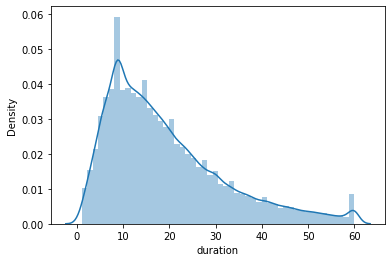

In [85]:
sns.distplot(df_train.duration)

In [88]:
len(df_train), len(df_val)

(171670, 129032)

# Building The Model

In [89]:
# Training and Validation sets

categorical = ['PUlocationID', 'DOlocationID']

dv = DictVectorizer()

# training
train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Validation
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [97]:
#Dimensionality after OHE
X_train.shape, X_val.shape

((171670, 2), (129032, 2))

In [90]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [91]:
#RMSE on Train dataset

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

12.738863762359012

In [92]:
#RMSE on Val dataset

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)


13.153084025977014